In [2]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax

In [3]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP,MLP2

2024-11-01 13:28:15.487522: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [5]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[]
)

In [6]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    obs = obs.at[2].set((3*4700 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

In [7]:
@eqx.filter_jit
def motor_env_dat_gen_sin(env,reset_env, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset_env(env,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset_env(env,subkey)  
    return init_obs, ref_obs, rng

In [8]:
@eqx.filter_jit
def featurize(obs,ref_obs):
    feat_obs=jnp.concatenate([obs[0:2],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs

In [9]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2], key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [10]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,-2:])**2,axis=1))
    return loss

In [11]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [12]:
data_batch_size=50
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=5000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [13]:
import matplotlib.pyplot as plt
from utils.evaluation import steps_eval

## Different omega

In [17]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    obs = obs.at[2].set((3*4700 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=5000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)

100%|██████████| 5000/5000 [04:41<00:00, 17.77it/s]


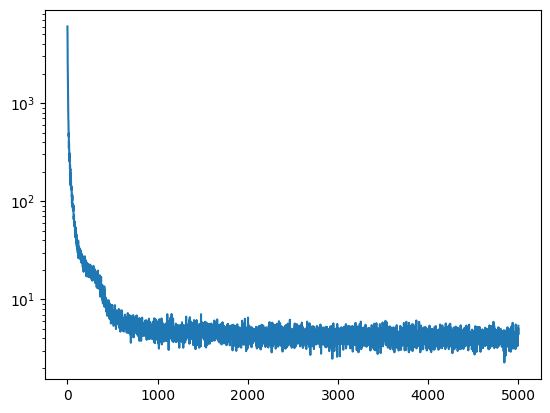

In [18]:
fin_policy1,fin_opt_state1,fin_keys1,losses1=trainer.fit_non_jit(policy,motor_env,keys,opt_state)
plt.plot(losses1)
plt.yscale('log')

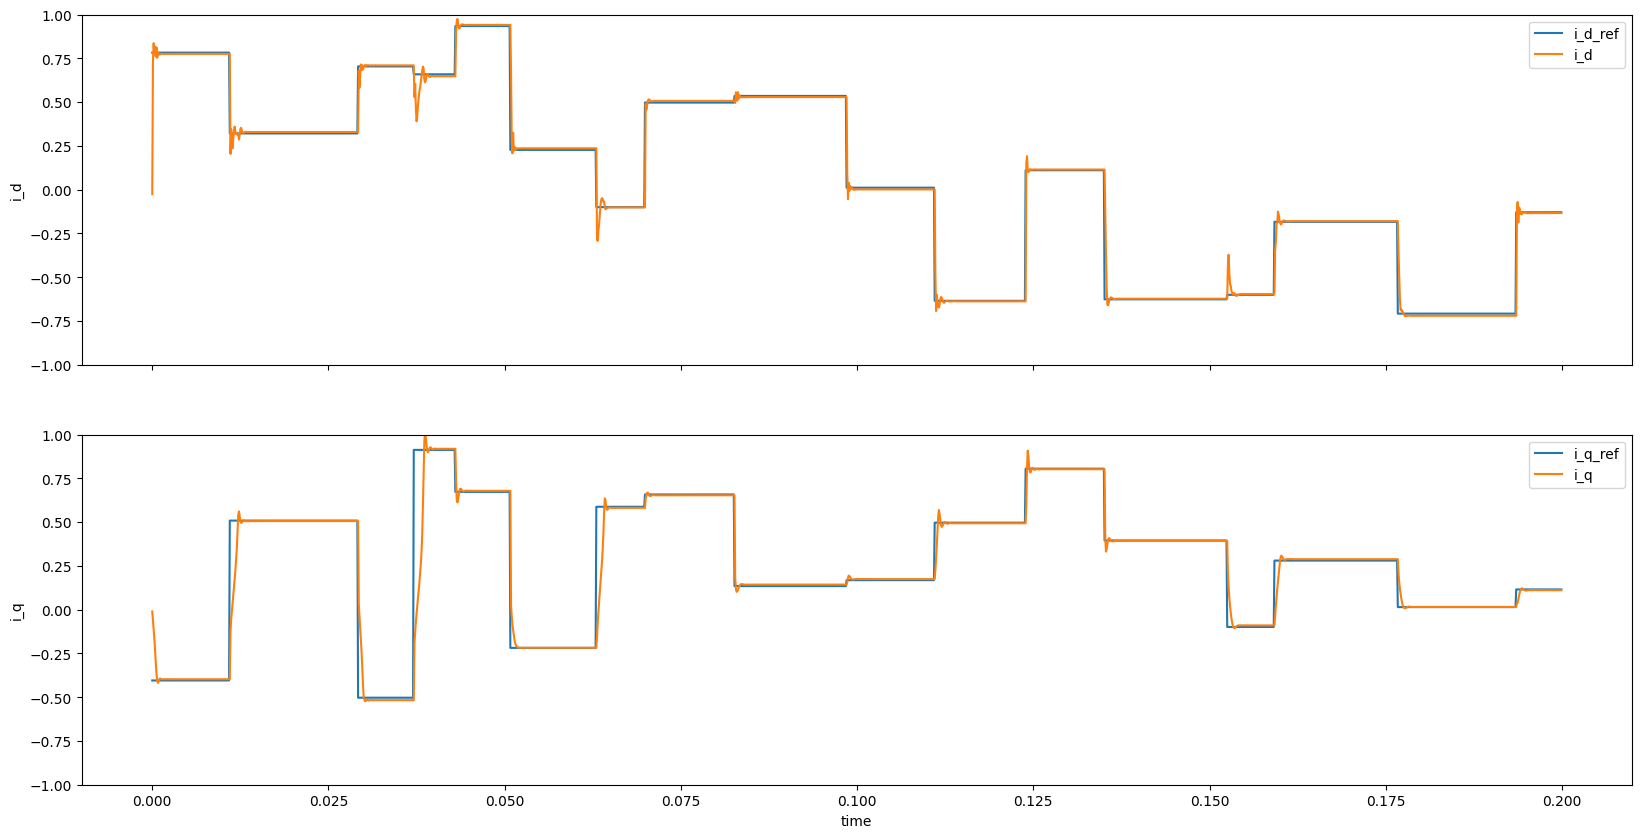

In [19]:
_,_,_=steps_eval(motor_env,reset_env,fin_policy1,featurize,jax.random.PRNGKey(2),2000)

In [20]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=5000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:32<00:00, 18.32it/s]


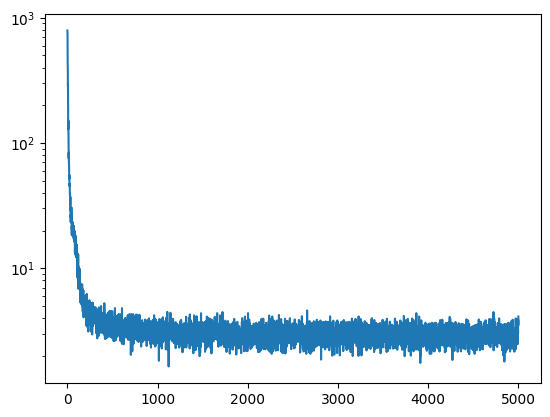

In [21]:
fin_policy2,fin_opt_state2,fin_keys2,losses2=trainer.fit_non_jit(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

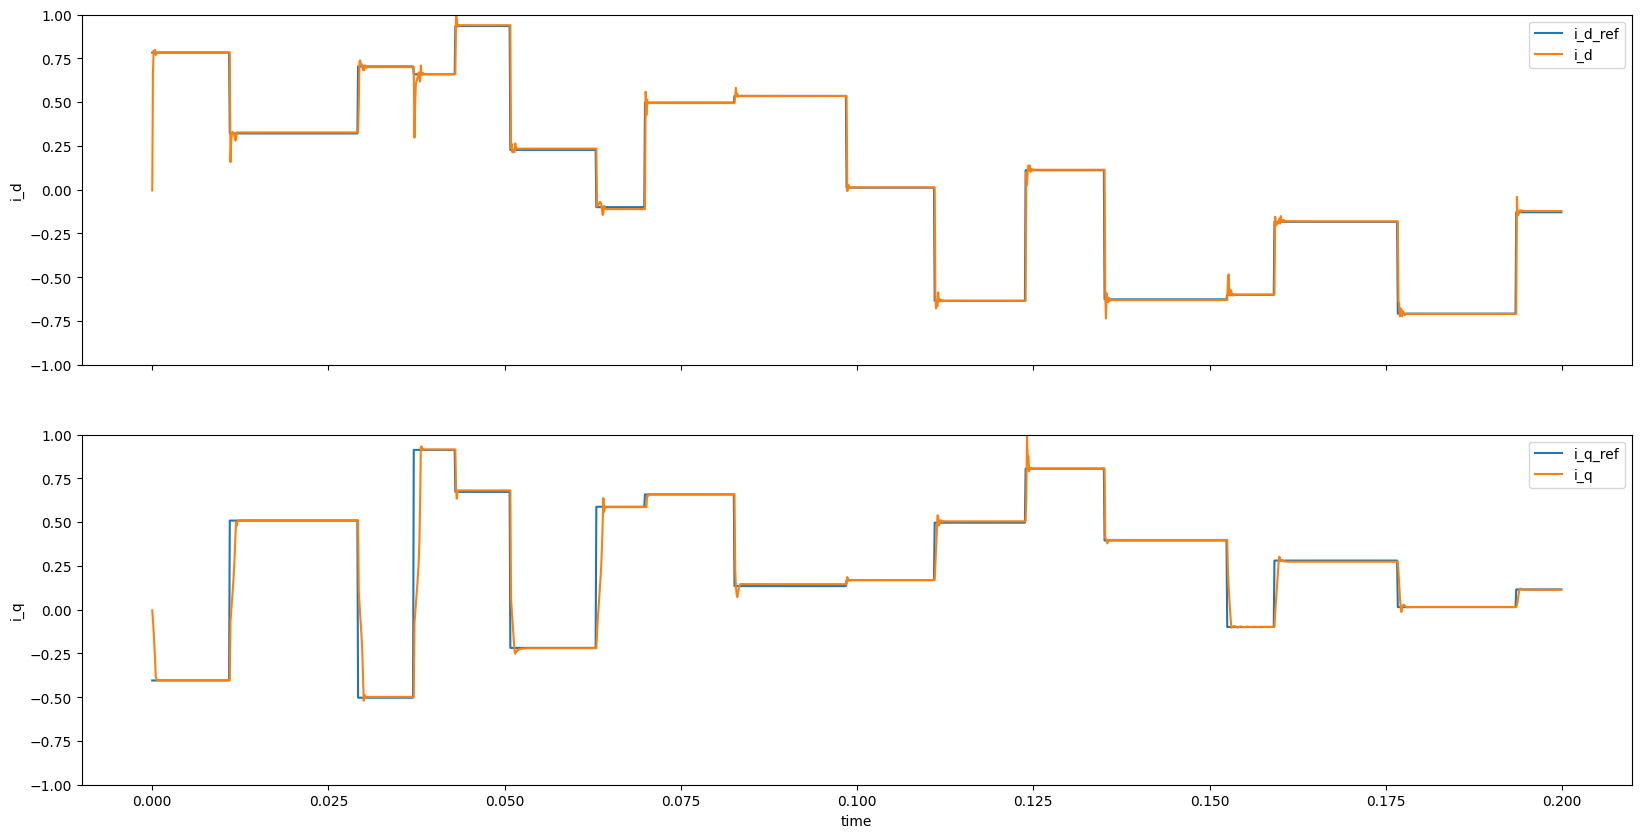

In [22]:
_,_,_=steps_eval(motor_env,reset_env,fin_policy2,featurize,jax.random.PRNGKey(2),2000)

## Learning with variable omega

In [19]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    return obs

@eqx.filter_jit
def featurize(obs,ref_obs):
    feat_obs=jnp.concatenate([obs[0:2],obs[2:3],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs

In [23]:
jax_key = jax.random.PRNGKey(2)
policy_dif_omega=MLP([9,64,64,64,2], key=jax_key)
optimizer = optax.adam(5e-4)
opt_state_dif_omega = optimizer.init(policy_dif_omega)

In [24]:
data_batch_size=50
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=5000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))

100%|██████████| 5000/5000 [04:34<00:00, 18.20it/s]


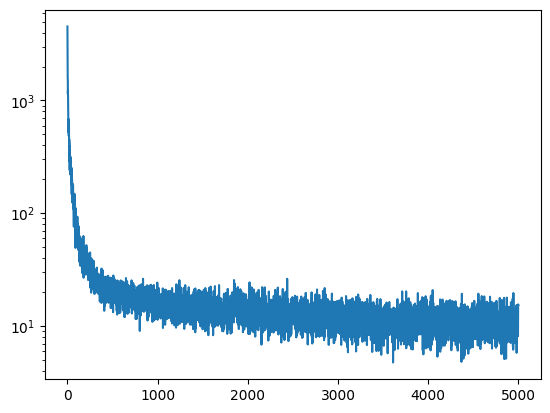

In [25]:
fin_policy_dif_omega,fin_opt_state2,fin_keys2,losses2=trainer.fit_non_jit(policy_dif_omega,motor_env,keys,opt_state_dif_omega)
plt.plot(losses2)
plt.yscale('log')

0.8430178


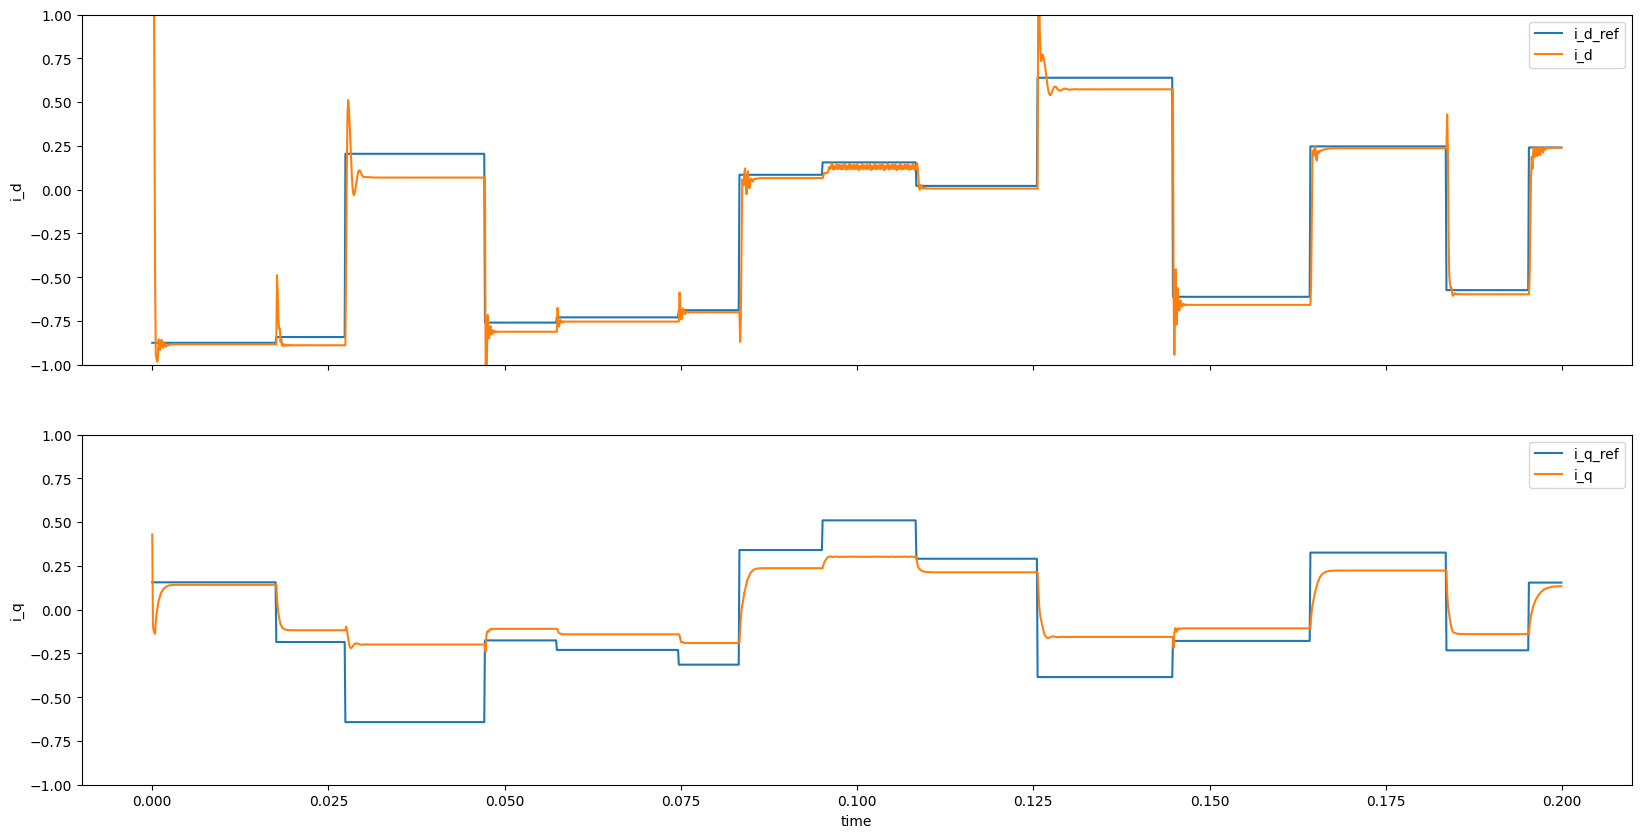

In [ ]:
obs,_,_=steps_eval(motor_env,reset_env,fin_policy_dif_omega,featurize,jax.random.PRNGKey(5),2000,init_obs_key=jax.random.PRNGKey(7))